In [1]:
from openpyxl import load_workbook

In [2]:
import numpy as np 
import pandas as pd 

## DOWNLOADING HISTORICAL DATA

from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder

gamefinder = leaguegamefinder.LeagueGameFinder()
allgames = games = gamefinder.get_data_frames()[0]
nba_teams = teams.get_teams()
nba_id = [t['id'] for t in nba_teams]
nba = allgames[allgames.TEAM_ID.isin(nba_id)]
nba['TEAM_ABBREVIATION'].unique().tolist()


import time

all_teams = []


for i, t_id in enumerate(nba_id):
  print(f'Fetching team {i+1}')
  gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=t_id)
  all_teams.extend(gamefinder.get_data_frames())
  time.sleep(60)

all_teams = pd.concat(all_teams, axis=0)
file = 'all_games.csv'

all_teams.to_csv(file)


Fetching team 1
Fetching team 2
Fetching team 3
Fetching team 4
Fetching team 5
Fetching team 6
Fetching team 7
Fetching team 8
Fetching team 9
Fetching team 10
Fetching team 11
Fetching team 12
Fetching team 13
Fetching team 14
Fetching team 15
Fetching team 16
Fetching team 17
Fetching team 18
Fetching team 19
Fetching team 20
Fetching team 21
Fetching team 22
Fetching team 23
Fetching team 24
Fetching team 25
Fetching team 26
Fetching team 27
Fetching team 28
Fetching team 29
Fetching team 30


In [3]:
# Changelog
# - 12/27/2023 -
#   - Sample Ranges
#      -Changed training period to begin from 2012
#      -Validation Period from 2020 - 2023
#      -Test Period from 2023 onwards
#   - Model Score
#      - Added option to perform extensive cross-validation
#      
#    - Production Model
#      - After CV and Backtest, the model is refit on the entire dataset
#      - Added LIME Explanation for each prediction
#

In [4]:
# PARAMETERS

TRAIN_START = '2012-01-01'
VAL_START = '2020-01-01'
TEST_START = '2023-01-01'
DATA_FILE = 'all_games.csv'
GRID_SEARCH = True
# Copy-pasted from grid-search
BEST_XGB_PARAMS = {'n_estimators': 1000,
 'learning_rate': 0.005,
 'max_depth': 3,
 'min_child_weight': 7,
 'alpha': 1,
 'subsample': 0.6,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'reg_alpha': 0.01}


In [5]:
## ML FEATURE GEN 

import pandas as pd
import numpy as np
import math
import xgboost as xgb
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



df = pd.read_csv(DATA_FILE, parse_dates=['GAME_DATE']).drop('Unnamed: 0', axis=1).dropna(subset=['WL'], how='any')

df = df[df['WL'].isin(['W', 'L'])]

#
#Which Seasons get ignored
#
df = df[~df['GAME_ID'].astype('str').str.startswith('1')].reset_index(drop=True)
chk = df.groupby('GAME_ID').count()

valid_games = chk[chk.iloc[:, 0] == 2].index

df = df[df['GAME_ID'].isin(valid_games)]
df['Home'] = df['MATCHUP'].str.contains('vs.')


# Add winning and losing streaks

def streak(x):
    x['WIN_STREAK'] = x.groupby( (x['WL'] != 'W').cumsum()).cumcount() + \
                  ( (x['WL'] != 'W').cumsum() == 0).astype(int) 
    x['LOSE_STREAK'] = x.groupby( (x['WL'] != 'L').cumsum()).cumcount() + \
                  ( (x['WL'] != 'L').cumsum() == 0).astype(int) 

    return x

df = df.sort_values(by=['TEAM_ID', 'GAME_DATE'])
df = df.groupby(['TEAM_ID', 'SEASON_ID']).apply(streak).reset_index(drop=True)

stats = ['PTS', 'FGM' , 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF'] 



## STACK HOME VS AWAY 

Home = df[df['Home']]
Away = df[~df['Home']]

Home = Home.sort_values(by=['TEAM_ID', 'GAME_DATE'])
Away = Away.sort_values(by=['TEAM_ID', 'GAME_DATE'])

chk = Away.groupby('GAME_ID').count()
Away = Away[Away['GAME_ID'].isin(chk[chk.iloc[:, 0] == 1].index)]

Merged = Home.merge(
    Away[[c for c in Away.columns if c not in ['SEASON_ID', 'MATCHUP', 'GAME_DATE', 'MIN', 'Home']]], 
    on=['GAME_ID'], 
    suffixes=['_HOME', '_AWAY'],
    how='left'
)

# Redo Spread where it is null
Merged['PLUS_MINUS_HOME'] = Merged['PTS_HOME'] - Merged['PTS_AWAY']
Merged['PLUS_MINUS_AWAY'] = -Merged['PTS_HOME'] + Merged['PTS_AWAY']
Merged = Merged.sort_values(by=['GAME_DATE','TEAM_ID_HOME'])

#ELO 


def win_probs(home_elo, away_elo, home_court_advantage):
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400) 

    denom = r + a*h
    home_prob = a*h / denom
    away_prob = r / denom 
    return home_prob, away_prob
    
def elo_k(spread, elo_diff):
    k = 20
    if spread>0:
        multiplier=(spread+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-spread+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier
    
def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
    home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

    if (home_score - away_score > 0) :
        home_win = 1 
        away_win = 0 
    else :
        home_win = 0 
        away_win = 1 
  
    k = elo_k(home_score - away_score, home_elo - away_elo)

    updated_home_elo = home_elo + k * (home_win - home_prob) 
    updated_away_elo = away_elo + k * (away_win - away_prob)

    return updated_home_elo, updated_away_elo

def season_reset(all_elo):
    all_elo = {key: value * .75+1505*.25 for key, value in all_elo.items()}

 
    return all_elo


def generate_elo_scores(df):
    df=df.sort_values(['GAME_DATE','GAME_ID'])

    season_ids=[df.loc[0,'SEASON_ID']]
    team_ids=list(df['TEAM_ID_HOME'].unique())
    current_elo = {i: 1500 for i in team_ids}
    df['ELO_PRIOR_HOME']=0
    df['ELO_PRIOR_AWAY']=0
    df['ELO_NEW_HOME']=0
    df['ELO_NEW_AWAY']=0    

    for index , row in df.iterrows():
        if row['SEASON_ID'] in (season_ids):

            df.loc[index,'ELO_PRIOR_HOME']= current_elo[df.loc[index,'TEAM_ID_HOME']]
            df.loc[index,'ELO_PRIOR_AWAY']= current_elo[df.loc[index,'TEAM_ID_AWAY']]


            new_elo=update_elo(df.loc[index,'PTS_HOME'],df.loc[index,'PTS_AWAY'],df.loc[index,'ELO_PRIOR_HOME'],df.loc[index,'ELO_PRIOR_AWAY'],71)
            df.loc[index,'ELO_NEW_HOME']=new_elo[0]
            df.loc[index,'ELO_NEW_AWAY']=new_elo[1]
            current_elo[df.loc[index,'TEAM_ID_HOME']]=new_elo[0]
            current_elo[df.loc[index,'TEAM_ID_AWAY']]=new_elo[1]

        else:
            season_ids.append(df.loc[index,'SEASON_ID'])
            current_elo=season_reset(current_elo)
            df.loc[index,'ELO_PRIOR_HOME']= current_elo[df.loc[index,'TEAM_ID_HOME']]
            df.loc[index,'ELO_PRIOR_AWAY']= current_elo[df.loc[index,'TEAM_ID_AWAY']]


            new_elo=update_elo(df.loc[index,'PTS_HOME'],df.loc[index,'PTS_AWAY'],df.loc[index,'ELO_PRIOR_HOME'],df.loc[index,'ELO_PRIOR_AWAY'],71)
            df.loc[index,'ELO_NEW_HOME']=new_elo[0]
            df.loc[index,'ELO_NEW_AWAY']=new_elo[1]
            current_elo[df.loc[index,'TEAM_ID_HOME']]=new_elo[0]
            current_elo[df.loc[index,'TEAM_ID_AWAY']]=new_elo[1]
    return df

def add_rest(df):
    with_days=df
    with_days=with_days.reset_index()
    team_ids=df['TEAM_ID_HOME'].unique()
    last_game = {i: with_days.loc[0,'GAME_DATE']-pd.Timedelta(11, "d") for i in team_ids}
    with_days['REST_HOME']=0
    with_days['REST_AWAY']=0
    for index , row in with_days.iterrows():
            with_days.loc[index,'REST_HOME']= np.minimum((with_days.loc[index,'GAME_DATE']-last_game[with_days.loc[index,'TEAM_ID_HOME']]).days-1,10)
            with_days.loc[index,'REST_AWAY']= np.minimum((with_days.loc[index,'GAME_DATE']-last_game[with_days.loc[index,'TEAM_ID_AWAY']]).days-1,10)
            last_game[with_days.loc[index,'TEAM_ID_HOME']]=with_days.loc[index,'GAME_DATE']
            last_game[with_days.loc[index,'TEAM_ID_AWAY']]=with_days.loc[index,'GAME_DATE']
    return with_days

Merged = generate_elo_scores(Merged)
Merged = add_rest(Merged)

#OTHER STUFF AND ROLLING STATS


common_cols = ['SEASON_ID', 'MATCHUP', 'GAME_DATE', 'MIN', 'Home', 'GAME_ID']
home_cols = [c for c in Merged.columns if c.endswith('_HOME')]
away_cols = [c for c in Merged.columns if c.endswith('_AWAY')]

home = Merged[common_cols + home_cols].rename(columns={k:k.replace('_HOME', '') for k in home_cols if k.endswith('_HOME')}).reset_index(drop=True)
away = Merged[common_cols + away_cols].rename(columns={k:k.replace('_AWAY', '') for k in away_cols if k.endswith('_AWAY')}).reset_index(drop=True)
away['Home'] = False
away['MATCHUP'] = away['MATCHUP'].str.replace('vs.', '@')

d = pd.concat([home,away], axis=0, ignore_index=True)
d = d.sort_values(by=['TEAM_ID', 'GAME_DATE']).reset_index(drop=True)

rolling_stats = d.groupby(['TEAM_ID']).rolling(10, min_periods=1)[stats].mean().shift().reset_index(drop=True).rename(
    columns={s:f'{s}_roll_10' for s in stats}
)

d = pd.concat([d, rolling_stats], axis=1)

d[stats + ['WIN_STREAK', 'LOSE_STREAK', 'WL']] = d.groupby('TEAM_ID')[stats + ['WIN_STREAK', 'LOSE_STREAK', 'WL']].shift()


## d[d['Home']], d[~d['Home']]
Home = d[d['Home']]
Away = d[~d['Home']]

Home = Home.sort_values(by=['TEAM_ID', 'GAME_DATE'])
Away = Away.sort_values(by=['TEAM_ID', 'GAME_DATE'])

chk = Away.groupby('GAME_ID').count()
Away = Away[Away['GAME_ID'].isin(chk[chk.iloc[:, 0] == 1].index)]

Merged = Home.merge(
    Away[[c for c in Away.columns if c not in ['SEASON_ID', 'MATCHUP', 'GAME_DATE', 'MIN', 'Home']]], 
    on=['GAME_ID'], 
    suffixes=['_HOME', '_AWAY'],
    how='left'
)

# Redo Spread where it is null
Merged = Merged.sort_values(by=['GAME_DATE','TEAM_ID_HOME'])



d = Merged
d['WL_HOME'] = np.where(d['WL_HOME'] == 'W', 1, 0)
d['WL_AWAY'] = np.where(d['WL_AWAY'] == 'W', 1, 0)

data_main = d.copy()
# d1 = pd.get_dummies(d['TEAM_ID_HOME']).astype(int)
# d1 = d1.rename(columns={k:f'{k}_HOME' for k in d1.columns})
# d2 = pd.get_dummies(d['TEAM_ID_AWAY']).astype(int)
# d2 = d1.rename(columns={k:f'{k}_AWAY' for k in d2.columns})

# d = pd.concat([d, d1, d2], axis=1)

/var/folders/dj/m6nn6p2x1_7dsrn_bb1016r80000gn/T/ipykernel_30987/915347324.py:132: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1513.531686394196' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index,'ELO_NEW_HOME']=new_elo[0]
/var/folders/dj/m6nn6p2x1_7dsrn_bb1016r80000gn/T/ipykernel_30987/915347324.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1486.468313605804' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index,'ELO_NEW_AWAY']=new_elo[1]
/var/folders/dj/m6nn6p2x1_7dsrn_bb1016r80000gn/T/ipykernel_30987/915347324.py:127: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1489.7306709936893' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

In [6]:
d

SEASON_ID      MATCHUP  GAME_DATE  MIN  Home   GAME_ID  TEAM_ID_HOME  \
3555       21983  CLE vs. NYK 1983-10-28  240  True  28300008    1610612739   
9687       21983  DEN vs. UTH 1983-10-28  240  True  28300009    1610612743   
20007      21983  MIL vs. IND 1983-10-28  240  True  28300001    1610612749   
23139      21983  NJN vs. ATL 1983-10-28  240  True  28300005    1610612751   
29752      21983  PHL vs. WAS 1983-10-28  240  True  28300003    1610612755   
...          ...          ...        ...  ...   ...       ...           ...   
9686       22023  DAL vs. MEM 2024-01-09  240  True  22300515    1610612742   
18438      22023  LAL vs. TOR 2024-01-09  241  True  22300516    1610612747   
26565      22023  NYK vs. POR 2024-01-09  240  True  22300514    1610612752   
28008      22023  ORL vs. MIN 2024-01-09  240  True  22300513    1610612753   
47758      22023  DET vs. SAC 2024-01-09  242  True  22300512    1610612765   

      TEAM_ABBREVIATION_HOME       TEAM_NAME_HOME  WL_HOME  ...  \
3555                     CLE  Cleveland Cavaliers        0  ...   
9687                     DEN       Denver Nuggets        0  ...   
20007                    MIL      Milwaukee Bucks        0  ...   
23139                    NJN      New Jersey Nets        0  ...   
29752                    PHL   Philadelphia 76ers        0  ...   
...                      ...                  ...      ...  ...   
9686                     DAL     Dallas Mavericks        1  ...   
18438                    LAL   Los Angeles Lakers        1  ...   
26565                    NYK      New York Knicks        1  ...   
28008                    ORL        Orlando Magic        1  ...   
47758                    DET      Detroit Pistons        0  ...   

       FTA_roll_10_AWAY  FT_PCT_roll_10_AWAY  OREB_roll_10_AWAY  \
3555               28.0               0.7073               14.2   
9687               23.5               0.7432                9.1   
20007              26.6               0.7591               11.1   
23139               NaN                  NaN                NaN   
29752              23.6               0.7813                9.4   
...                 ...                  ...                ...   
9686               23.6               0.7623                8.4   
18438              23.5               0.7509                9.6   
26565              23.4               0.7649               12.7   
28008              25.0               0.7898                8.5   
47758              19.3               0.6846               10.4   

       DREB_roll_10_AWAY  REB_roll_10_AWAY  AST_roll_10_AWAY  \
3555                31.9              46.1              27.0   
9687                33.0              42.1              31.6   
20007               32.8              43.9              23.7   
23139                NaN               NaN               NaN   
29752               35.1              44.5              26.3   
...                  ...               ...               ...   
9686                34.8              43.2              26.3   
18438               32.9              42.5              30.8   
26565               30.4              43.1              23.7   
28008               31.9              40.4              25.2   
47758               32.0              42.4              29.4   

       STL_roll_10_AWAY  BLK_roll_10_AWAY  TOV_roll_10_AWAY  PF_roll_10_AWAY  
3555                7.5               4.5              10.4             19.9  
9687                7.7               5.7              10.7             19.5  
20007               8.5               5.3              14.9             21.0  
23139               NaN               NaN               NaN              NaN  
29752               7.2               6.2              13.4             19.3  
...                 ...               ...               ...              ...  
9686                7.3               6.6              13.6             18.9  
18438               7.2               5.8      

In [7]:
## XGBOOST

In [8]:
from sklearn.metrics import *
xg_data = data_main.copy()

# xg_data['DAY_OF_WEEK'] =  xg_data['GAME_DATE'].dt.day_of_week
# xg_data['MONTH'] =  xg_data['GAME_DATE'].dt.month


cat_cols = ['TEAM_ID_HOME','WL_HOME','TEAM_ID_AWAY']#, 'DAY_OF_WEEK', 'MONTH']
for col in cat_cols:
    xg_data[col] = pd.Categorical(xg_data[col])

feature_cols = [c for c in xg_data.columns if c.endswith('AWAY') or c.endswith('HOME')]

exclude_cols = ['GAME_ID_HOME', 'TEAM_ID_HOME', 'TEAM_ABBREVIATION_HOME', 'TEAM_NAME_HOME', 'ELO_NEW_HOME', 'PLUS_MINUS_HOME', 'GAME_ID_AWAY', 'TEAM_ID_AWAY', 'TEAM_ABBREVIATION_AWAY', 'TEAM_NAME_AWAY', 'ELO_NEW_AWAY', 'PLUS_MINUS_AWAY']

feature_cols = [f for f in feature_cols if f not in exclude_cols]

train_xgb = xg_data[(xg_data['GAME_DATE'] < TEST_START) & (xg_data['GAME_DATE'] > TRAIN_START) ]
test_xgb = xg_data[xg_data['GAME_DATE'] >= TEST_START]

train_y_xgb = train_xgb['PLUS_MINUS_HOME']
train_X_xgb = train_xgb[feature_cols]

In [9]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from xgboost import plot_importance
import matplotlib.pyplot as plt
import multiprocessing

loss = mean_squared_error
cv_score = 'neg_mean_squared_error'

def grid_search(base_params, search_space, X, y):
    xgb_reg = xgb.XGBRegressor(
        obj=loss,
        tree_method="hist",
        enable_categorical=True,
        seed=420,
        **base_params
    )
    
    grid_search = GridSearchCV(
        estimator=xgb_reg,
        param_grid=search_space,
        scoring = cv_score,
        n_jobs = multiprocessing.cpu_count()-1 ,
        verbose=1,
        pre_dispatch=multiprocessing.cpu_count() // 2
    )
    
    grid_search.fit(X, y)

    return grid_search.best_params_



if GRID_SEARCH:
    base_params = {
         'n_estimators': 1000,
         'learning_rate': 0.1,
         'max_depth': 7,
         'min_child_weight': 1,
         'alpha': 1,         
         'subsample': 0.8,
         'colsample_bytree': 0.8,
         'gamma': 0.1,
         'learning_rate': 0.01,
    }
    


    base_params.update(grid_search(
        base_params,
        {
            'n_estimators': [300, 500, 1000, 2000, 3000],
            'learning_rate': [0.005, 0.01, 0.05, 0.1]
        },
        train_X_xgb, 
        train_y_xgb
    ))    
    
    base_params.update(grid_search(
        base_params,
        {
            'max_depth': range(3, 10, 1),
            'min_child_weight': range(1, 8, 1)
        },
        train_X_xgb, 
        train_y_xgb
    )) 

    base_params.update(grid_search(
        base_params,
        {
            'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        },
        train_X_xgb, 
        train_y_xgb
    )) 

    base_params.update(grid_search(
        base_params,
        {
            'subsample': [0.6, 0.7, 0.8, 0.9],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9]        
        },
        train_X_xgb, 
        train_y_xgb
    )) 

    base_params.update(grid_search(
        base_params,
        {
            'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
        },
        train_X_xgb, 
        train_y_xgb
    )) 

    base_params.update(grid_search(
        base_params,
        {
            'n_estimators': [500, 1000, 2000, 3000],
            'learning_rate': [0.005, 0.01, 0.05, 0.1]

        },
        train_X_xgb, 
        train_y_xgb
    ))      

    best_params = base_params

else:
    best_params = BEST_XGB_PARAMS



Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

Fitting 5 folds for each of 49 candidates, totalling 245 fits


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  o

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  ret

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spars

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  ret

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  ret

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  o

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `is

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-pac

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  ret

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_categorical_dtype(dtype) and enable_categorical)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be remo

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `is

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nulla

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

In [10]:
best_params

{'n_estimators': 1000,
 'learning_rate': 0.005,
 'max_depth': 4,
 'min_child_weight': 7,
 'alpha': 1,
 'subsample': 0.6,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'reg_alpha': 0.05}

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

IS R2 : 0.22647868849141561 | Error : 150.0541535911585
OOS R2 : 0.15031613372914487 | Error : 177.94847866095276


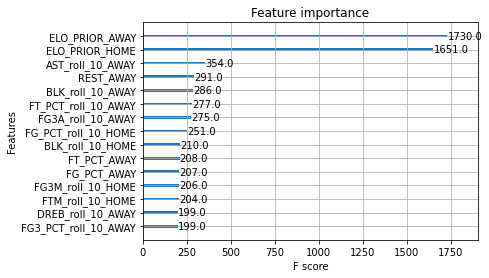

In [11]:
xgbr = xgb.XGBRegressor(
    obj=loss,
    n_jobs=6,
    enable_categorical=True,
    tree_method='hist',
    **best_params
)

xgbr.fit(train_X_xgb, train_y_xgb)


pred_xgbr = xgbr.predict(test_xgb[feature_cols])

print(f'IS R2 : {r2_score(train_y_xgb, xgbr.predict(train_X_xgb))} | Error : {loss(train_y_xgb, xgbr.predict(train_X_xgb))}')
print(f'OOS R2 : {r2_score(test_xgb.PLUS_MINUS_HOME, xgbr.predict(test_xgb[feature_cols]))} | Error : {loss(test_xgb.PLUS_MINUS_HOME, xgbr.predict(test_xgb[feature_cols]))}')
pred_xgb = test_xgb[['PLUS_MINUS_HOME', 'GAME_DATE', 'TEAM_NAME_HOME', 'TEAM_NAME_AWAY']].copy() 
pred_xgb['XGB'] = xgbr.predict(test_xgb[feature_cols])
# backtest(pred_xgb, 'XGB')


plot_importance(xgbr, max_num_features = 15)
plt.show()

In [12]:
## Backtest 

In [13]:
def get_side(spred_pred, home_betting_spread, cutoff):
    if(np.abs(spred_pred + home_betting_spread) > cutoff):
        if(spred_pred + home_betting_spread < 0):
            return "AWAY"
        else:
            return "HOME"
    else: 
        return "NO BET"

def get_payoff(spread, home_betting_spread, bet, home_spread_price, away_spread_price):
    if(-spread == home_betting_spread):
        return 0
    elif(-spread < home_betting_spread):
        if(bet == "HOME"):
            return home_spread_price - 1
        elif(bet == "AWAY"):
            return -1
        else:
            return 0
    else:
        if(bet == "HOME"):
            return -1
        elif(bet == "AWAY"):
            return away_spread_price - 1
        else:
            return 0
        
        
        
def backtest(pred, model_name):
    odds = pd.read_csv("betting_2020.csv")
    odds['GAME_TIME'] = pd.to_datetime(odds['ODDS_TIME'])
    odds['GAME_TIME'] = odds['GAME_TIME'].dt.date
    odds = odds[['GAME_TIME', 'HOME_TEAM', 'AWAY_TEAM', 'HOME_SPREAD_ODDS', 'HOME_SPREAD_PRICE', 'AWAY_SPREAD_PRICE']]
    pred["HOME_TEAM"] = pred['TEAM_NAME_HOME']
    odds["GAME_DATE"] = odds["GAME_TIME"]
    odds["GAME_DATE"] = pd.to_datetime(odds["GAME_DATE"])
    pred["GAME_DATE"] = pd.to_datetime(pred["GAME_DATE"])
    merged_df = pd.merge(pred, odds, on = ['GAME_DATE', 'HOME_TEAM'], how = 'inner')
    merged_df = merged_df.dropna()
    cutoff = 0
    df = merged_df.copy()
    df["SIDE"] = 0
    for index , row in df.iterrows():
        df.loc[index,"SIDE"] = get_side(df.loc[index,model_name], df.loc[index,"HOME_SPREAD_ODDS"], cutoff)
    df["PAYOFF"] = 0
    for index , row in df.iterrows():
        df.loc[index,"PAYOFF"] = get_payoff(df.loc[index,'PLUS_MINUS_HOME'], df.loc[index,'HOME_SPREAD_ODDS'], df.loc[index,'SIDE'], df.loc[index,'HOME_SPREAD_PRICE'], df.loc[index,'AWAY_SPREAD_PRICE'])






    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    # Keep only one row for each combination of 'GAME_DATE' and 'TEAM_NAME_HOME'
    df = df.drop_duplicates(subset=['GAME_DATE', 'TEAM_NAME_HOME'])






    df['W/L'] = df['PAYOFF'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    num_losses = df['W/L'].value_counts().get(-1, 0)
    num_wins = df['W/L'].value_counts().get(1, 0)
    win_percentage = (num_wins / (num_losses + num_wins)) * 100





    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    # Sort the DataFrame based on the 'date' column
    df = df.sort_values(by='GAME_DATE')

    def find_worst_streak(df, window_size=20):
        max_diff = 0
        start_index = 0

        for i in range(len(df) - window_size + 1):
            window = df['W/L'].iloc[i:i + window_size]
            total_wins = sum(1 for result in window if result == 1)
            total_losses = sum(1 for result in window if result == -1)
            diff = total_losses - total_wins

            if diff > max_diff:
                max_diff = diff
                start_index = i

        return start_index, start_index + window_size - 1

    # Find the window with the most losses compared to wins
    start, end = find_worst_streak(df)
    worst_window = df.iloc[start:end + 1]
    print(f"The worst window of losses to wins is:\n{worst_window}")
    new_num_losses = worst_window['W/L'].value_counts().get(-1, 0)
    print('Total Number of Losses: ' + str(new_num_losses))




    print(f'Model : {model_name}')
    print("Strategy Win Percentage Is: " + str(round(win_percentage, 4)) + "%")
    dollar_return = df['PAYOFF'].sum() / len(df)
    print("Average Profit on a $1 Bet With Our Strategy: $" + str(round(dollar_return, 2)))

In [14]:
backtest(pred_xgb, 'XGB')

/var/folders/dj/m6nn6p2x1_7dsrn_bb1016r80000gn/T/ipykernel_30987/1915950679.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AWAY' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index,"SIDE"] = get_side(df.loc[index,model_name], df.loc[index,"HOME_SPREAD_ODDS"], cutoff)
/var/folders/dj/m6nn6p2x1_7dsrn_bb1016r80000gn/T/ipykernel_30987/1915950679.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9099999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index,"PAYOFF"] = get_payoff(df.loc[index,'PLUS_MINUS_HOME'], df.loc[index,'HOME_SPREAD_ODDS'], df.loc[index,'SIDE'], df.loc[index,'HOME_SPREAD_PRICE'], df.loc[index,'AWAY_SPREAD_PRICE'])


The worst window of losses to wins is:
     PLUS_MINUS_HOME  GAME_DATE          TEAM_NAME_HOME  \
656               25 2023-04-14  Minnesota Timberwolves   
658                3 2023-04-15        Sacramento Kings   
662               29 2023-04-16          Denver Nuggets   
666                8 2023-04-17        Sacramento Kings   
668               14 2023-04-18            Phoenix Suns   
671                9 2023-04-19          Denver Nuggets   
674               -9 2023-04-21  Minnesota Timberwolves   
677               10 2023-04-22      Los Angeles Lakers   
681                6 2023-04-23  Minnesota Timberwolves   
685                6 2023-04-24      Los Angeles Lakers   
687                6 2023-04-25            Phoenix Suns   
690               -7 2023-04-26        Sacramento Kings   
694               -8 2023-04-27           Atlanta Hawks   
695               40 2023-04-28      Los Angeles Lakers   
697               18 2023-04-29          Denver Nuggets   
698              

In [15]:
schedule=pd.read_excel('2023-2024 NBA Schedule.xls')
schedule=schedule[['Date','Visitor/Neutral','Home/Neutral']]
schedule

Date         Visitor/Neutral            Home/Neutral
0     Tue, Oct 24, 2023      Los Angeles Lakers          Denver Nuggets
1     Tue, Oct 24, 2023            Phoenix Suns   Golden State Warriors
2     Wed, Oct 25, 2023         Houston Rockets           Orlando Magic
3     Wed, Oct 25, 2023          Boston Celtics         New York Knicks
4     Wed, Oct 25, 2023      Washington Wizards          Indiana Pacers
...                 ...                     ...                     ...
1195  Sun, Apr 14, 2024            Phoenix Suns  Minnesota Timberwolves
1196  Sun, Apr 14, 2024      Los Angeles Lakers    New Orleans Pelicans
1197  Sun, Apr 14, 2024        Dallas Mavericks   Oklahoma City Thunder
1198  Sun, Apr 14, 2024  Portland Trail Blazers        Sacramento Kings
1199  Sun, Apr 14, 2024         Detroit Pistons       San Antonio Spurs

[1200 rows x 3 columns]

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

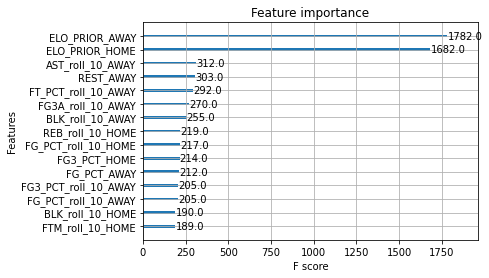

In [16]:
final_data = xg_data[xg_data['GAME_DATE'] >= TRAIN_START]

xgbr = xgb.XGBRegressor(
    obj=loss,
    n_jobs=6,
    enable_categorical=True,
    tree_method='hist',
    **best_params
)

xgbr.fit(final_data[feature_cols], final_data['PLUS_MINUS_HOME'])

plot_importance(xgbr, max_num_features = 15)
plt.show()

In [17]:
team_map = df.sort_values(by=['TEAM_NAME', 'GAME_DATE']).groupby('TEAM_NAME')['TEAM_ID'].last().to_dict()
schedule['Visitor_ID'] = schedule['Visitor/Neutral'].map(team_map)
schedule['Home_ID'] = schedule['Home/Neutral'].map(team_map)

In [18]:
schedule

Date         Visitor/Neutral            Home/Neutral  \
0     Tue, Oct 24, 2023      Los Angeles Lakers          Denver Nuggets   
1     Tue, Oct 24, 2023            Phoenix Suns   Golden State Warriors   
2     Wed, Oct 25, 2023         Houston Rockets           Orlando Magic   
3     Wed, Oct 25, 2023          Boston Celtics         New York Knicks   
4     Wed, Oct 25, 2023      Washington Wizards          Indiana Pacers   
...                 ...                     ...                     ...   
1195  Sun, Apr 14, 2024            Phoenix Suns  Minnesota Timberwolves   
1196  Sun, Apr 14, 2024      Los Angeles Lakers    New Orleans Pelicans   
1197  Sun, Apr 14, 2024        Dallas Mavericks   Oklahoma City Thunder   
1198  Sun, Apr 14, 2024  Portland Trail Blazers        Sacramento Kings   
1199  Sun, Apr 14, 2024         Detroit Pistons       San Antonio Spurs   

      Visitor_ID     Home_ID  
0     1610612747  1610612743  
1     1610612756  1610612744  
2     1610612745  1610612753  
3     1610612738  1610612752  
4     1610612764  1610612754  
...          ...         ...  
1195  1610612756  1610612750  
1196  1610612747  1610612740  
1197  1610612742  1610612760  
1198  1610612757  1610612758  
1199  1610612765  1610612759  

[1200 rows x 5 columns]

In [19]:
from datetime import date, timedelta

# Get today's date
today = date.today()

# desired_date = datetime(today.year, today.month, today.day)

In [20]:
today

datetime.date(2024, 1, 10)

In [21]:
schedule['Date'] = pd.to_datetime(schedule['Date'], format='%a, %b %d, %Y')
schedule[schedule['Date']==(pd.Timestamp.today() - pd.Timedelta(days=0)).round('D')]

Date         Visitor/Neutral           Home/Neutral  Visitor_ID  \
526 2024-01-11           Brooklyn Nets    Cleveland Cavaliers  1610612751   
527 2024-01-11          Boston Celtics        Milwaukee Bucks  1610612738   
528 2024-01-11  Portland Trail Blazers  Oklahoma City Thunder  1610612757   
529 2024-01-11         New York Knicks       Dallas Mavericks  1610612752   
530 2024-01-11            Phoenix Suns     Los Angeles Lakers  1610612756   

        Home_ID  
526  1610612739  
527  1610612749  
528  1610612760  
529  1610612742  
530  1610612747

In [22]:
df = pd.read_csv(DATA_FILE, parse_dates=['GAME_DATE']).drop('Unnamed: 0', axis=1).dropna(subset=['WL'], how='any')

df = df[df['WL'].isin(['W', 'L'])]

#
#Which Seasons get ignored
#
df = df[~df['GAME_ID'].astype('str').str.startswith('1')].reset_index(drop=True)
chk = df.groupby('GAME_ID').count()

valid_games = chk[chk.iloc[:, 0] == 2].index

df = df[df['GAME_ID'].isin(valid_games)]
df['Home'] = df['MATCHUP'].str.contains('vs.')


# Add winning and losing streaks

def streak(x):
    x['WIN_STREAK'] = x.groupby( (x['WL'] != 'W').cumsum()).cumcount() + \
                  ( (x['WL'] != 'W').cumsum() == 0).astype(int) 
    x['LOSE_STREAK'] = x.groupby( (x['WL'] != 'L').cumsum()).cumcount() + \
                  ( (x['WL'] != 'L').cumsum() == 0).astype(int) 

    return x

df = df.sort_values(by=['TEAM_ID', 'GAME_DATE'])
df = df.groupby(['TEAM_ID', 'SEASON_ID']).apply(streak).reset_index(drop=True)

stats = ['PTS', 'FGM' , 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF'] 



## STACK HOME VS AWAY 

Home = df[df['Home']]
Away = df[~df['Home']]

Home = Home.sort_values(by=['TEAM_ID', 'GAME_DATE'])
Away = Away.sort_values(by=['TEAM_ID', 'GAME_DATE'])

chk = Away.groupby('GAME_ID').count()
Away = Away[Away['GAME_ID'].isin(chk[chk.iloc[:, 0] == 1].index)]

Merged = Home.merge(
    Away[[c for c in Away.columns if c not in ['SEASON_ID', 'MATCHUP', 'GAME_DATE', 'MIN', 'Home']]], 
    on=['GAME_ID'], 
    suffixes=['_HOME', '_AWAY'],
    how='left'
)

# Redo Spread where it is null
Merged['PLUS_MINUS_HOME'] = Merged['PTS_HOME'] - Merged['PTS_AWAY']
Merged['PLUS_MINUS_AWAY'] = -Merged['PTS_HOME'] + Merged['PTS_AWAY']
Merged = Merged.sort_values(by=['GAME_DATE','TEAM_ID_HOME'])
Merged

SEASON_ID  TEAM_ID_HOME TEAM_ABBREVIATION_HOME       TEAM_NAME_HOME  \
3555       21983    1610612739                    CLE  Cleveland Cavaliers   
9687       21983    1610612743                    DEN       Denver Nuggets   
20007      21983    1610612749                    MIL      Milwaukee Bucks   
23139      21983    1610612751                    NJN      New Jersey Nets   
29752      21983    1610612755                    PHL   Philadelphia 76ers   
...          ...           ...                    ...                  ...   
9686       22023    1610612742                    DAL     Dallas Mavericks   
18438      22023    1610612747                    LAL   Los Angeles Lakers   
26565      22023    1610612752                    NYK      New York Knicks   
28008      22023    1610612753                    ORL        Orlando Magic   
47758      22023    1610612765                    DET      Detroit Pistons   

        GAME_ID  GAME_DATE      MATCHUP WL_HOME  MIN  PTS_HOME  ...  \
3555   28300008 1983-10-28  CLE vs. NYK       L  240       106  ...   
9687   28300009 1983-10-28  DEN vs. UTH       W  240       139  ...   
20007  28300001 1983-10-28  MIL vs. IND       W  240       104  ...   
23139  28300005 1983-10-28  NJN vs. ATL       W  240       126  ...   
29752  28300003 1983-10-28  PHL vs. WAS       W  240       117  ...   
...         ...        ...          ...     ...  ...       ...  ...   
9686   22300515 2024-01-09  DAL vs. MEM       L  240       103  ...   
18438  22300516 2024-01-09  LAL vs. TOR       W  241       132  ...   
26565  22300514 2024-01-09  NYK vs. POR       W  240       112  ...   
28008  22300513 2024-01-09  ORL vs. MIN       L  240        92  ...   
47758  22300512 2024-01-09  DET vs. SAC       L  242       110  ...   

       DREB_AWAY  REB_AWAY  AST_AWAY  STL_AWAY  BLK_AWAY  TOV_AWAY  PF_AWAY  \
3555        19.0      35.0        26       9.0         3        17       33   
9687        27.0      37.0        32       6.0         8         7       30   
20007       29.0      53.0        27       7.0         4        19       22   
23139       18.0      33.0        14      10.0         5        17       30   
29752       26.0      36.0        32       9.0         3        21       35   
...          ...       ...       ...       ...       ...       ...      ...   
9686        36.0      54.0        27       7.0         3        16       18   
18438       32.0      37.0        34       8.0         4        12       26   
26565       31.0      43.0        19       8.0         7        15       17   
28008       43.0      48.0        34       8.0         4        18       18   
47758       34.0      44.0        39       8.0         6        17       21   

       PLUS_MINUS_AWAY  WIN_STREAK_AWAY  LOSE_STREAK_AWAY  
3555                15                1                 0  
9687               -14                0                 1  
20007              -21                0                 1  
23139              -18                0                 1  
29752               -3                0                 1  
...                ...              ...               ...  
9686                17                3                 0  
18438               -1                0                 1  
26565              -28                0                 1  
28008               21                1                 0  
47758               21                1                 0  

[49117 rows x 56 columns]

In [23]:
desired_value = 'LAC'
filtered_rows = Merged[Merged['TEAM_ABBREVIATION_HOME'] == desired_value]
filtered_rows

SEASON_ID  TEAM_ID_HOME TEAM_ABBREVIATION_HOME        TEAM_NAME_HOME  \
14938      21984    1610612746                    LAC  Los Angeles Clippers   
14939      21984    1610612746                    LAC  Los Angeles Clippers   
14940      21984    1610612746                    LAC  Los Angeles Clippers   
14941      21984    1610612746                    LAC  Los Angeles Clippers   
14942      21984    1610612746                    LAC  Los Angeles Clippers   
...          ...           ...                    ...                   ...   
16580      22023    1610612746                    LAC           LA Clippers   
16581      22023    1610612746                    LAC           LA Clippers   
16582      22023    1610612746                    LAC           LA Clippers   
16583      22023    1610612746                    LAC           LA Clippers   
16584      22023    1610612746                    LAC           LA Clippers   

        GAME_ID  GAME_DATE      MATCHUP WL_HOME  MIN  PTS_HOME  ...  \
14938  28400037 1984-11-01  LAC vs. NYK       W  240       107  ...   
14939  28400049 1984-11-03  LAC vs. POR       L  240       112  ...   
14940  28400057 1984-11-05  LAC vs. DEN       W  240       107  ...   
14941  28400098 1984-11-13  LAC vs. NJN       L  234        90  ...   
14942  28400109 1984-11-15  LAC vs. MIL       L  240        90  ...   
...         ...        ...          ...     ...  ...       ...  ...   
16580  22300389 2023-12-23  LAC vs. BOS       L  240       108  ...   
16581  22300414 2023-12-26  LAC vs. CHA       W  239       113  ...   
16582  22300438 2023-12-29  LAC vs. MEM       W  240       117  ...   
16583  22300458 2024-01-01  LAC vs. MIA       W  241       121  ...   
16584  22300511 2024-01-08  LAC vs. PHX       W  241       138  ...   

       DREB_AWAY  REB_AWAY  AST_AWAY  STL_AWAY  BLK_AWAY  TOV_AWAY  PF_AWAY  \
14938       24.0      38.0        17      13.0         5        25       37   
14939       29.0      48.0        26       8.0         5        16       24   
14940       22.0      36.0        25       6.0         2        12       22   
14941       18.0      30.0        23      12.0         2         8       17   
14942       31.0      49.0        25       9.0         8        16       24   
...          ...       ...       ...       ...       ...       ...      ...   
16580       36.0      51.0        33       4.0         5         9       19   
16581       34.0      42.0        31       8.0         6        11       23   
16582       30.0      33.0        29      10.0         4        12       22   
16583       23.0      35.0        24       7.0         3        13       17   
16584       20.0      25.0        17       6.0         4        14       20   

       PLUS_MINUS_AWAY  WIN_STREAK_AWAY  LOSE_STREAK_AWAY  
14938               -2                0                 2  
14939               19                1                 0  
14940               -3                0                 1  
14941                9                1                 0  
14942               13                2                 0  
...                ...              ...               ...  
16580               37                2                 0  
16581               -9                0                 8  
16582              -11                0                 2  
16583              -17                0                 2  
16584              -27                0                 2  

[1647 rows x 56 columns]

In [24]:
Merged = generate_elo_scores(Merged)
Merged = add_rest(Merged)

common_cols = ['SEASON_ID', 'MATCHUP', 'GAME_DATE', 'MIN', 'Home', 'GAME_ID']
home_cols = [c for c in Merged.columns if c.endswith('_HOME')]
away_cols = [c for c in Merged.columns if c.endswith('_AWAY')]

home = Merged[common_cols + home_cols].rename(columns={k:k.replace('_HOME', '') for k in home_cols if k.endswith('_HOME')}).reset_index(drop=True)
away = Merged[common_cols + away_cols].rename(columns={k:k.replace('_AWAY', '') for k in away_cols if k.endswith('_AWAY')}).reset_index(drop=True)
away['Home'] = False
away['MATCHUP'] = away['MATCHUP'].str.replace('vs.', '@')

d = pd.concat([home,away], axis=0, ignore_index=True)
d = d.sort_values(by=['TEAM_ID', 'GAME_DATE']).reset_index(drop=True)

rolling_stats = d.groupby(['TEAM_ID']).rolling(10, min_periods=1)[stats].mean().reset_index(drop=True).rename(
    columns={s:f'{s}_roll_10' for s in stats}
)

d = pd.concat([d, rolling_stats], axis=1)

# d[stats + ['WIN_STREAK', 'LOSE_STREAK', 'WL']] = d.groupby('TEAM_ID')[stats + ['WIN_STREAK', 'LOSE_STREAK', 'WL']].first()


## d[d['Home']], d[~d['Home']]
Home = d[d['Home']]
Away = d[~d['Home']]

Home = Home.sort_values(by=['TEAM_ID', 'GAME_DATE'])
Away = Away.sort_values(by=['TEAM_ID', 'GAME_DATE'])

chk = Away.groupby('GAME_ID').count()
Away = Away[Away['GAME_ID'].isin(chk[chk.iloc[:, 0] == 1].index)]

Merged = Home.merge(
    Away[[c for c in Away.columns if c not in ['SEASON_ID', 'MATCHUP', 'GAME_DATE', 'MIN', 'Home']]], 
    on=['GAME_ID'], 
    suffixes=['_HOME', '_AWAY'],
    how='left'
)

# Redo Spread where it is null
Merged = Merged.sort_values(by=['GAME_DATE','TEAM_ID_HOME'])



d = Merged
d['WL_HOME'] = np.where(d['WL_HOME'] == 'W', 1, 0)
d['WL_AWAY'] = np.where(d['WL_AWAY'] == 'W', 1, 0)

data_main = d.copy()
d1 = pd.get_dummies(d['TEAM_ID_HOME']).astype(int)
d1 = d1.rename(columns={k:f'{k}_HOME' for k in d1.columns})
d2 = pd.get_dummies(d['TEAM_ID_AWAY']).astype(int)
d2 = d1.rename(columns={k:f'{k}_AWAY' for k in d2.columns})

d = pd.concat([d, d1, d2], axis=1)

/var/folders/dj/m6nn6p2x1_7dsrn_bb1016r80000gn/T/ipykernel_30987/915347324.py:132: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1513.531686394196' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index,'ELO_NEW_HOME']=new_elo[0]
/var/folders/dj/m6nn6p2x1_7dsrn_bb1016r80000gn/T/ipykernel_30987/915347324.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1486.468313605804' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index,'ELO_NEW_AWAY']=new_elo[1]
/var/folders/dj/m6nn6p2x1_7dsrn_bb1016r80000gn/T/ipykernel_30987/915347324.py:127: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1489.7306709936893' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

In [37]:
todays_games = schedule[schedule['Date']==(pd.Timestamp.today() - pd.Timedelta(days=1)).round('D')].copy()
last_rows_per_matchup = d.sort_values(by=['TEAM_ID_HOME', 'TEAM_ID_AWAY', 'GAME_DATE']).groupby(['TEAM_ID_HOME', 'TEAM_ID_AWAY']).last().reset_index()


In [38]:
todays_features = todays_games.merge(
    last_rows_per_matchup, 
    left_on=['Home_ID', 'Visitor_ID'], 
    right_on=['TEAM_ID_HOME', 'TEAM_ID_AWAY'],
    how='left'
)

In [39]:
preds = todays_features[['MATCHUP', 'Date']].copy()
preds['Predicted Spread'] = xgbr.predict(todays_features[feature_cols])
preds                               

/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/harrysanchez/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  ret

MATCHUP       Date  Predicted Spread
0  BOS vs. MIN 2024-01-10          6.642433
1  CHA vs. SAC 2024-01-10          5.510165
2  DET vs. SAS 2024-01-10          1.529712
3  IND vs. WAS 2024-01-10          0.763226
4  ATL vs. PHI 2024-01-10         -0.395733
5  MIA vs. OKC 2024-01-10          4.311343
6  CHI vs. HOU 2024-01-10          7.496791
7  UTA vs. DEN 2024-01-10         -3.337185
8  GSW vs. NOP 2024-01-10          4.047904
9  LAC vs. TOR 2024-01-10          2.465165

### Generating Odds Set

In [44]:
import os

dfs = []

# Loop through each year folder
for year_folder in os.listdir('archive (2)'):
    year_path = os.path.join('archive (2)', year_folder)

    # Check if the path is a directory
    if os.path.isdir(year_path):
        # Construct the file path for vegas.txt
        file_path = os.path.join(year_path, 'vegas.txt')

        # Check if vegas.txt exists in the current year folder
        if os.path.exists(file_path):
            # Read the content of vegas.txt into a DataFrame
            df = pd.read_csv(file_path, delimiter=',')  # Adjust the delimiter if needed
            # Add a column for the year
            df['Year'] = year_folder
            # Append the DataFrame to the list
            dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)


In [48]:
combined_df=combined_df[combined_df['Location']=='home']
combined_df.sort_values('Date')

Date Location           Team        OppTeam      TeamId  \
12291  2012-10-30     home      Cleveland     Washington  1610612739   
12293  2012-10-30     home          Miami         Boston  1610612748   
12295  2012-10-30     home    L.A. Lakers         Dallas  1610612747   
12313  2012-10-31     home       Portland    L.A. Lakers  1610612757   
12311  2012-10-31     home  L.A. Clippers        Memphis  1610612746   
...           ...      ...            ...            ...         ...   
7361   2019-04-10     home        Memphis   Golden State  1610612763   
7363   2019-04-10     home      Milwaukee  Oklahoma City  1610612749   
7365   2019-04-10     home    San Antonio         Dallas  1610612759   
7351   2019-04-10     home        Atlanta        Indiana  1610612737   
7371   2019-04-10     home       Portland     Sacramento  1610612757   

         GameId  PercentBet_ML  Open_Line_ML  Pinnacle_ML  5dimes_ML  ...  \
12291  21200001           55.4        -260.0       -235.0     -240.0  ...   
12293  21200002           55.2        -260.0       -275.0     -260.0  ...   
12295  21200003           59.2        -425.0       -460.0     -475.0  ...   
12313  21200012           52.8         135.0        113.0      110.0  ...   
12311  21200011           69.7        -170.0       -172.0     -170.0  ...   
...         ...            ...           ...          ...        ...  ...   
7361   21801225           65.0         155.0        182.0      185.0  ...   
7363   21801226           43.8         148.0        181.0      175.0  ...   
7365   21801227           41.7       -1600.0      -1113.0    -1150.0  ...   
7351   21801220           69.0        -161.0       -220.0     -225.0  ...   
7371   21801230           41.9        -400.0       -149.0     -145.0  ...   

       Average_Odds_OU  Best_Line_OU  Worst_Line_OU  Best_Odds_OU  \
12291          -110.17         191.0          187.0        -106.0   
12293          -109.33         188.0          182.0        -105.0   
12295          -109.17         187.0          185.0        -105.0   
12313          -109.67         192.0          190.5        -108.0   
12311          -109.83         188.0          186.0        -107.0   
...                ...           ...            ...           ...   
7361           -111.00         219.0          214.0        -105.0   
7363           -106.17         230.0          227.0        -102.0   
7365           -109.17         219.0          218.0        -105.0   
7351           -105.83         227.0          223.5        -105.0   
7371           -107.33         229.0          226.5        -100.0   

       Worst_Odds_OU    Pts  Spread  Result  Total     Year  
12291         -115.0   94.0    10.0       W  178.0  2012-13  
12293         -115.0  120.0    13.0       W  227.0  2012-13  
12295         -110.0   91.0    -8.0       L  190.0  2012-13  
12313         -110.0  116.0    10.0       W  222.0  2012-13  
12311         -115.0  101.0     9.0       W  193.0  2012-13  
...              ...    ...     ...     ...    ...      ...  
7361          -133.0  132.0    15.0       W  249.0  2018-19  
7363          -110.0  116.0   -11.0       L  243.0  2018-19  
7365          -115.0  105.0    11.0       W  199.0  2018-19  
7351          -110.0  134.0    -1.0       L  269.0  2018-19  
7371          -115.0  136.0     5.0       W  267.0  2018-19  

[8604 rows x 59 columns]

In [49]:
combined_df.columns

Index(['Date', 'Location', 'Team', 'OppTeam', 'TeamId', 'GameId',
       'PercentBet_ML', 'Open_Line_ML', 'Pinnacle_ML', '5dimes_ML',
       'Heritage_ML', 'Bovada_ML', 'Betonline_ML', 'Average_Line_ML',
       'Best_Line_ML', 'Worst_Line_ML', 'PercentBet_Spread',
       'Open_Line_Spread', 'Open_Odds_Spread', 'Pinnacle_Line_Spread',
       'Pinnacle_Odds_Spread', '5dimes_Line_Spread', '5dimes_Odds_Spread',
       'Heritage_Line_Spread', 'Heritage_Odds_Spread', 'Bovada_Line_Spread',
       'Bovada_Odds_Spread', 'Betonline_Line_Spread', 'Betonline_Odds_Spread',
       'Average_Line_Spread', 'Average_Odds_Spread', 'Best_Line_Spread',
       'Worst_Line_Spread', 'Best_Odds_Spread', 'Worst_Odds_Spread',
       'PercentBet_OU', 'Open_Line_OU', 'Open_Odds_OU', 'Pinnacle_Line_OU',
       'Pinnacle_Odds_OU', '5dimes_Line_OU', '5dimes_Odds_OU',
       'Heritage_Line_OU', 'Heritage_Odds_OU', 'Bovada_Line_OU',
       'Bovada_Odds_OU', 'Betonline_Line_OU', 'Betonline_Odds_OU',
       'Average_Line

## Use LIME to explain features

In [30]:
#pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=cacd9efd3d529640557e2efa7a7671aa333528d0ab6820d27c9e34ff6d07a2e3
  Stored in directory: /Users/harrysanchez/Library/Caches/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: /Users/harrysanchez/opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(
    final_data[feature_cols].values, 
    feature_names=feature_cols, 
    class_names=['PLUS_MINUS_HOME'], 
    verbose=True, 
    mode='regression'
)


In [36]:
exp = explainer.explain_instance(todays_features[feature_cols].values[0], xgbr.predict, num_features=10)
exp.show_in_notebook(show_table=True)


TypeError: solve() got an unexpected keyword argument 'sym_pos'

In [ ]:
exp = explainer.explain_instance(todays_features[feature_cols].values[1], xgbr.predict, num_features=10)
exp.show_in_notebook(show_table=True)


In [ ]:
exp = explainer.explain_instance(todays_features[feature_cols].values[7], xgbr.predict, num_features=10)
exp.show_in_notebook(show_table=True)


In [ ]:
todays_features[todays_features.columns[0:42]]

In [33]:
todays_features.columns[0:70]

Index(['Date', 'Visitor/Neutral', 'Home/Neutral', 'Visitor_ID', 'Home_ID',
       'TEAM_ID_HOME', 'TEAM_ID_AWAY', 'SEASON_ID', 'MATCHUP', 'GAME_DATE',
       'MIN', 'Home', 'GAME_ID', 'TEAM_ABBREVIATION_HOME', 'TEAM_NAME_HOME',
       'WL_HOME', 'PTS_HOME', 'FGM_HOME', 'FGA_HOME', 'FG_PCT_HOME',
       'FG3M_HOME', 'FG3A_HOME', 'FG3_PCT_HOME', 'FTM_HOME', 'FTA_HOME',
       'FT_PCT_HOME', 'OREB_HOME', 'DREB_HOME', 'REB_HOME', 'AST_HOME',
       'STL_HOME', 'BLK_HOME', 'TOV_HOME', 'PF_HOME', 'PLUS_MINUS_HOME',
       'WIN_STREAK_HOME', 'LOSE_STREAK_HOME', 'ELO_PRIOR_HOME', 'ELO_NEW_HOME',
       'REST_HOME', 'PTS_roll_10_HOME', 'FGM_roll_10_HOME', 'FGA_roll_10_HOME',
       'FG_PCT_roll_10_HOME', 'FG3M_roll_10_HOME', 'FG3A_roll_10_HOME',
       'FG3_PCT_roll_10_HOME', 'FTM_roll_10_HOME', 'FTA_roll_10_HOME',
       'FT_PCT_roll_10_HOME', 'OREB_roll_10_HOME', 'DREB_roll_10_HOME',
       'REB_roll_10_HOME', 'AST_roll_10_HOME', 'STL_roll_10_HOME',
       'BLK_roll_10_HOME', 'TOV_roll_10_HOM

In [34]:
preds.drop(['MATCHUP', 'Date'], axis = 1, inplace = True)

excel_file_path = 'Daily_Picks.xlsx'  # Replace with the desired name and path for your new Excel file

# Define the sheet name where you want to write the DataFrame
sheet_name = 'Sheet1'  # Replace with the name of the sheet you want to create

# Open a new Excel file and write the DataFrame to the specified sheet
with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    # Create a new workbook
    writer.book = writer.book

    # Write the DataFrame to the specified sheet

    df = pd.DataFrame(todays_features[todays_features.columns[1:3]])
    df.to_excel(writer, sheet_name=sheet_name, index=False)

    preds.to_excel(writer, sheet_name=sheet_name, startrow = 0, startcol=2, index=False)

    column_names = ['Person', 'Spread Bet', 'Team', 'Odds']
    column = pd.DataFrame(columns = column_names)
    column.to_excel(writer, sheet_name = sheet_name, startrow = 0, startcol = 3, index = False)

IndexError: At least one sheet must be visible